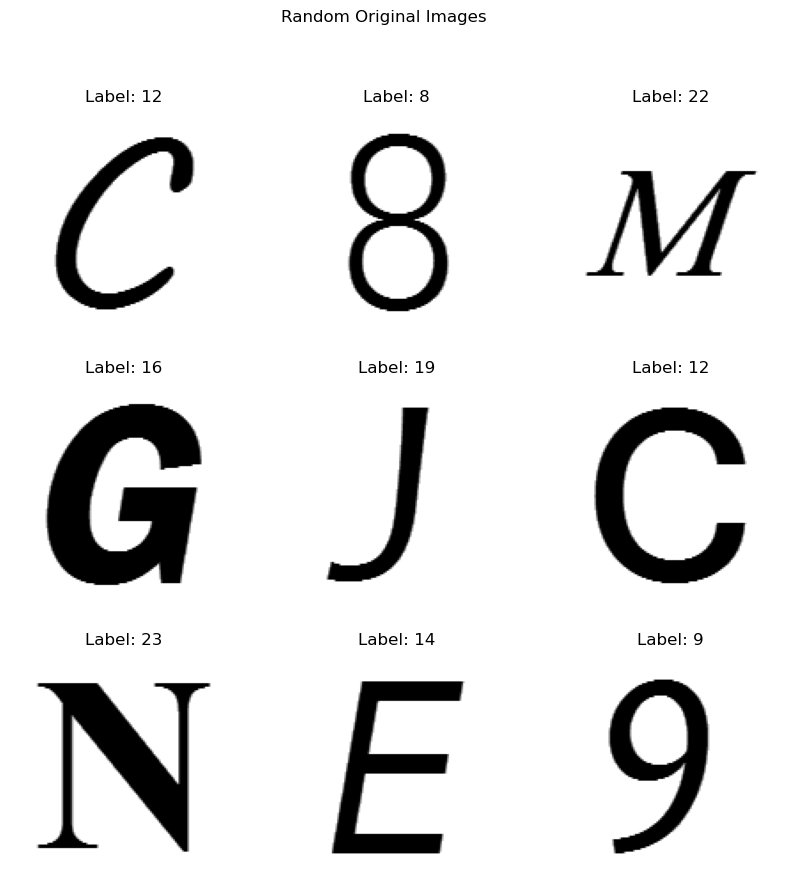

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from einops.layers.torch import Rearrange
from einops import repeat
from VIT_Model import VIT

# Load Data
def load_dir_into_df(directory='dataset'):
    im_paths_list = []
    im_labels_list = []
    class_dict = {}
    all_labels = []
    for i, dir in enumerate(sorted(os.listdir(directory))):
        class_dict[dir] = i
        all_labels.append(dir)
        for impath in sorted(os.listdir(os.path.join(directory, dir))):
            im_paths_list.append(os.path.join(directory, dir, impath))
            im_labels_list.append(i)
    df = pd.DataFrame({'img': im_paths_list, 'label': im_labels_list})
    return df, class_dict, all_labels

data_df, class_dict, all_labels = load_dir_into_df()

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        return img, label

# Data Preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Create dataset
dataset = CustomDataset(data_df['img'].values, data_df['label'].values, transform)

# Split into Train and Validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Visualize Random Images
def show_raw_images(dataset, title="Raw Images"):
    indices = np.random.choice(len(dataset), 9, replace=False)
    plt.figure(figsize=(10, 10))
    
    for i, idx in enumerate(indices):
        img_path = dataset.image_paths[idx]
        label = dataset.labels[idx]
        
        # Load original image
        img = Image.open(img_path).convert('RGB')  # Load raw image
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    
    plt.suptitle(title)
    plt.show()

# Call the function to show raw images
show_raw_images(dataset, title="Random Original Images")


D:\Anaconda\envs\torch\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch [1/20], Train Loss: 2.1654, Val Loss: 0.9217
Epoch [2/20], Train Loss: 0.7870, Val Loss: 0.5587
Epoch [3/20], Train Loss: 0.5438, Val Loss: 0.4435
Epoch [4/20], Train Loss: 0.4342, Val Loss: 0.3704
Epoch [5/20], Train Loss: 0.3650, Val Loss: 0.3217
Epoch [6/20], Train Loss: 0.3141, Val Loss: 0.3040
Epoch [7/20], Train Loss: 0.2737, Val Loss: 0.2487
Epoch [8/20], Train Loss: 0.2405, Val Loss: 0.2412
Epoch [9/20], Train Loss: 0.2156, Val Loss: 0.2285
Epoch [10/20], Train Loss: 0.1961, Val Loss: 0.1946
Epoch [11/20], Train Loss: 0.1822, Val Loss: 0.1901
Epoch [12/20], Train Loss: 0.1629, Val Loss: 0.1673
Epoch [13/20], Train Loss: 0.1475, Val Loss: 0.1635
Epoch [14/20], Train Loss: 0.1394, Val Loss: 0.1781
Epoch [15/20], Train Loss: 0.1299, Val Loss: 0.1523
Epoch [16/20], Train Loss: 0.1184, Val Loss: 0.1364
Epoch [17/20], Train Loss: 0.1121, Val Loss: 0.1230
Epoch [18/20], Train Loss: 0.1058, Val Loss: 0.1280
Epoch [19/20], Train Loss: 0.1002, Val Loss: 0.1340
Epoch [20/20], Train 

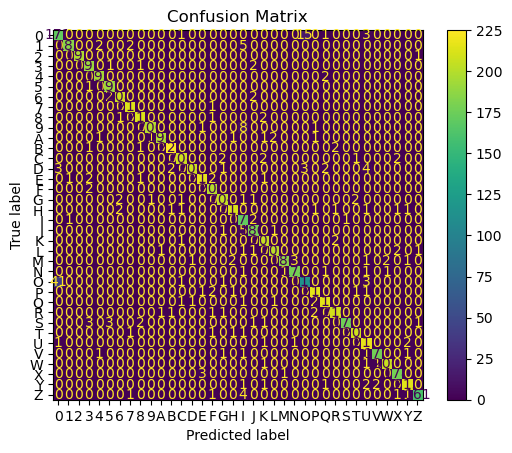

Final model saved successfully.


In [3]:

#train_images = [dataset[i][0].permute(1, 2, 0).numpy() for i in range(len(train_dataset))]
#train_labels = [dataset[i][1] for i in range(len(train_dataset))]
#label_to_idx = class_dict
#show_random_images(train_images, train_labels, label_to_idx, title="Random Training Images")

# Initialize the Vision Transformer Model
img_size = 224
patch_size = 16
embed_dim = 768
num_classes = len(all_labels)
num_heads = 12
hidden_dim = 3072
num_encoders = 12
dropout = 0.1
activation = "relu"
in_channels = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT(
    img_size=img_size,
    num_classes=num_classes,
    patch_size=patch_size,
    embed_dim=embed_dim,
    num_encoders=num_encoders,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
    dropout=dropout,
    activation=activation,
    in_channels=in_channels
).to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

# Training and Validation Loop
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Evaluate the Model
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect true and predicted labels for report
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the validation set: {accuracy:.2f}%')

# Classification Report
report = classification_report(y_true, y_pred, target_names=all_labels)
print(report)

# Confusion Matrix Visualization
confusion_mat = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=all_labels)
cm_display.plot()
plt.title('Confusion Matrix')
plt.show()

# Save the Model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
}, 'final_model.pth')

print('Final model saved successfully.')


C:\Users\amber\AppData\Local\Temp\ipykernel_15416\3243646367.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


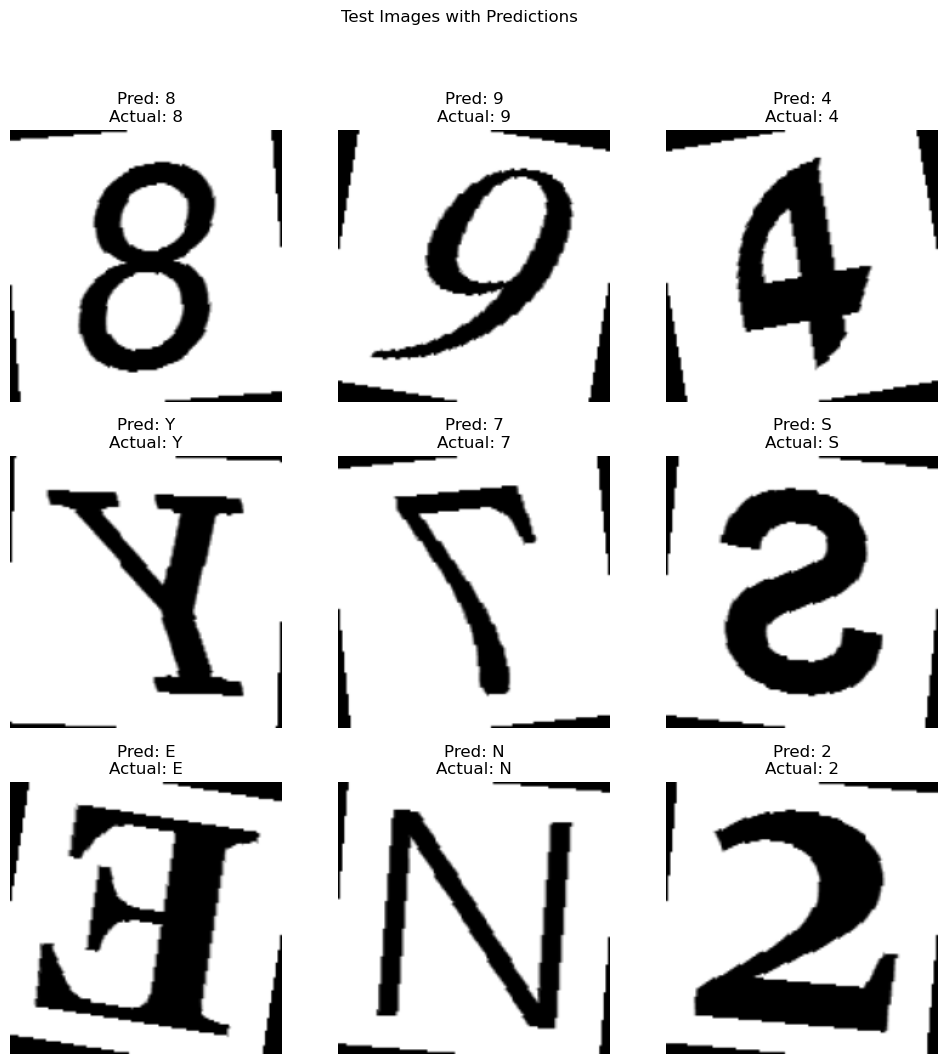

In [11]:
# Create data loaders
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

def load_model_and_test(model_path, model, val_loader, device, all_labels):
    # Load the saved model weights
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Prepare for evaluation
    y_true = []
    y_pred = []
    images_to_show = []
    actual_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Collect images and labels for visualization
            images_to_show.extend(images.cpu())
            actual_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Show a few test images with predicted and actual labels
    idx_to_label = {v: k for k, v in class_dict.items()}
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = images_to_show[i].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5)  # De-normalize
        plt.imshow(img)
        plt.title(f"Pred: {idx_to_label[predicted_labels[i]]}\nActual: {idx_to_label[actual_labels[i]]}")
        plt.axis('off')
    plt.suptitle("Test Images with Predictions")
    plt.show()



# Initialize and test model
img_size = 224
patch_size = 16
embed_dim = 768
num_classes = len(all_labels)
num_heads = 12
hidden_dim = 3072
num_encoders = 12
dropout = 0.1
activation = "relu"
in_channels = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT(
    img_size=img_size,
    num_classes=num_classes,
    patch_size=patch_size,
    embed_dim=embed_dim,
    num_encoders=num_encoders,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
    dropout=dropout,
    activation=activation,
    in_channels=in_channels
)

# Provide the path to the saved model
model_path = 'final_model.pth'
load_model_and_test(model_path, model, val_loader, device, all_labels)